# AI & DL, Лабораторная работа 2
## Семантическая сегментация

Выполнил Моисеенков Илья, 408Б

### Задание 
1. Написать валидацию на каждой эпохе
2. Написать расчет метрики IoU, (расчет должен быть векторным, выход тензор формы [BxC] где B - плоскость батча, С - класса)
3. Написать расчет метрики MIoU на основе IoU. Также представить IoU в среднем по датасету на последней валидации в развертке по классам.
(пользоваться уже написанным IoU)
5. Обучить модель на приемлемое качество (хотя бы 25% MIoU на валидации). (Отбирать лучшее качество на валидации, отдельные запуски логировать в csv табличку: номер пуска: MIoU в среднем по классам)
4. Отобрать по 2 картинки на основе метрики IoU (усредненной по классам) из 3 квантилей по качеству: картинки, при ранжировании по качеству попадающие в первые 10%,  в промежутке между 15% - 25%, и 45% - 55%. (пользоваться уже написанным IoU)
5. Отобрать лучшую по качеству IoU картинку по трем выбранным классам.
6. Посчитать таблицу IoU в развертке по кадому классу для лучшей модели.
* Таблицы, картинки, и ipynb-тетрадь собрать в архив. Картинки можно просто отобразить в тетради, уже без необходимости сохранения, как и таблицы. (Кроме таблицы с запусками, её приложить в архив).
* При обучении можете попробовать другие ФО, или аугментации. Модель тоже можете поменять. 






In [1]:
import torch, torchvision
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

## Датасет
Работать будем с датасетом VOC. Подготовим его

In [2]:
import cv2
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

Класс для работы с датасетом

In [3]:
class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        image,mask = torchvision.transforms.functional.to_tensor(image), torch.from_numpy(mask)
        mask = mask.permute(2,0,1)
        return image, mask

Для улучшения качества обучения будем использовать аугментации из библиотеки albumentations.

Валидационную выборке аугментировать не будем, только приведем ее к нужному размеру

In [4]:
from albumentations import Compose, RandomBrightnessContrast, RandomCrop, Flip, RandomSizedCrop, OneOf, PadIfNeeded, CenterCrop

In [5]:
augs = Compose([
    PadIfNeeded(448,448),
    RandomBrightnessContrast(),
    OneOf([
        RandomCrop(256,256, p=0.2),
        RandomSizedCrop((224,448),256,256)
    ], p =1)
])

val_augs = Compose([
    PadIfNeeded(448, 448),
    CenterCrop(256, 256)
])

Загрузим датасет

In [6]:
train = PascalVOCSearchDataset(
    root='.',
    image_set="train",
    download=True,
    transform=augs
)

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./VOCtrainval_11-May-2012.tar to .


In [7]:
val = PascalVOCSearchDataset(
    root='.',
    image_set="val",
    download=True,
    transform=val_augs
)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


Датасет состоит из тьюплов - картинки и лейблов

In [8]:
train[0][0].shape, train[0][1].shape

(torch.Size([3, 256, 256]), torch.Size([21, 256, 256]))

Посмотрим на пример картинки из датасета

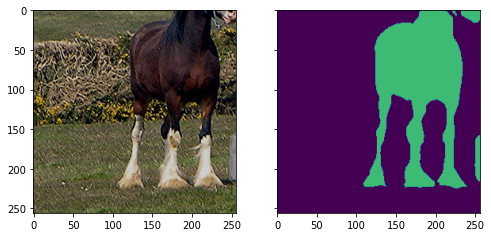

In [9]:
img, lbl = train[777]
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,6))
ax = ax.ravel()

ax[0].imshow(img.permute(1, 2, 0))
lbl_plot = ax[1].imshow(lbl.argmax(0), vmax=19)
# plt.colorbar(lbl_plot, ax=ax[1])
plt.show()

# Метрики

Для начала напишем расчет для метрики IoU.

$\large IoU = \frac{real \cap pred}{real \cup pred} = \frac{TP}{TP + FP + FN}$

In [10]:
def IoU(real, pred):
    # real: [batch_size, classes_num, h, w]
    # pred: [batch_size, classes_num, h, w]
    # output: [batch_size, classes_num]

    batch_size = real.shape[0]
    classes_num = real.shape[1]

    real = real.reshape(batch_size, classes_num, -1).long()
    pred = (
        F.one_hot(pred.argmax(axis=1), num_classes=classes_num)
        .permute(0, 3, 1, 2)
        .reshape(batch_size, classes_num, -1)
        .long()
    )

    intersection = (real & pred).sum(axis=-1)
    union = (real | pred).sum(axis=-1)
    iou = intersection / union
    return iou

И метрику MioU - Mean IoU. В каждом батче будем брать среднюю метрику по всем классам, где IoU не nan

In [11]:
def MIoU(real, pred):
    # real: [batch_size, classes_num, h, w]
    # pred: [batch_size, classes_num, h, w]
    # output: [batch_size]
    iou = IoU(real, pred)
    return iou.nanmean(axis=1)

# Модель

В качестве модели будем использовать предобученную deeplabv3_mobilenet_v3_large

In [12]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [13]:
model = deeplabv3_mobilenet_v3_large(weights=True, num_classes=len(VOC_CLASSES), progress=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth


  0%|          | 0.00/42.3M [00:00<?, ?B/s]

Оптимизатор - AdamW

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-5)

Лосс - кросс-энтропия

In [15]:
criterion = torch.nn.CrossEntropyLoss(label_smoothing=1e-5)

Подготовим даталоадеры

In [16]:
train_dataloader = DataLoader(train, batch_size=16, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val, batch_size=16, num_workers=2)

# Обучение

Подготовим пайплайн для обучения. На каждой эпохе будем считать валидацию

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
epochs = 5

train_losses = []
val_losses = []
train_miou = []
val_miou = []

model = model.to(device)

for epoch in tqdm(range(epochs)):
    # training
    cur_train_loss = 0
    cur_train_miou = 0
    train_samples_num = 0
    for images, labels in train_dataloader:
        train_samples_num += len(images)
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        preds = model(images)['out']
        loss = criterion(preds, labels)
        cur_train_loss += loss.detach().cpu().item()
        cur_train_miou += MIoU(labels.detach().cpu(), preds.detach().cpu()).sum()

        # backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    train_losses.append(cur_train_loss / train_samples_num)
    train_miou.append(cur_train_miou / train_samples_num)

    # validation
    cur_val_loss = 0
    cur_val_miou = 0
    val_samples_num = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            val_samples_num += len(images)
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)['out']
            loss = criterion(preds, labels)
            cur_val_loss += loss.detach().cpu().item()
            cur_val_miou += MIoU(labels.detach().cpu(), preds.detach().cpu()).sum()
    
    val_losses.append(cur_val_loss / val_samples_num)
    val_miou.append(cur_val_miou / val_samples_num)

    print(f'Epoch {epoch+1}')
    print(f'Train loss: {train_losses[-1]:.3f}. Train MIoU: {train_miou[-1]:.3f}')
    print(f'Val loss: {val_losses[-1]:.3f}. Val MIoU: {val_miou[-1]:.3f}')

 20%|██        | 1/5 [08:32<34:08, 512.07s/it]

Epoch 1
Train loss: 0.023. Train MIoU: 0.551
Val loss: 0.026. Val MIoU: 0.571


 40%|████      | 2/5 [16:57<25:25, 508.37s/it]

Epoch 2
Train loss: 0.020. Train MIoU: 0.575
Val loss: 0.026. Val MIoU: 0.576


 60%|██████    | 3/5 [25:19<16:50, 505.22s/it]

Epoch 3
Train loss: 0.018. Train MIoU: 0.593
Val loss: 0.024. Val MIoU: 0.580


 80%|████████  | 4/5 [33:45<08:25, 505.70s/it]

Epoch 4
Train loss: 0.017. Train MIoU: 0.590
Val loss: 0.024. Val MIoU: 0.585


100%|██████████| 5/5 [42:14<00:00, 506.80s/it]

Epoch 5
Train loss: 0.016. Train MIoU: 0.597
Val loss: 0.024. Val MIoU: 0.586


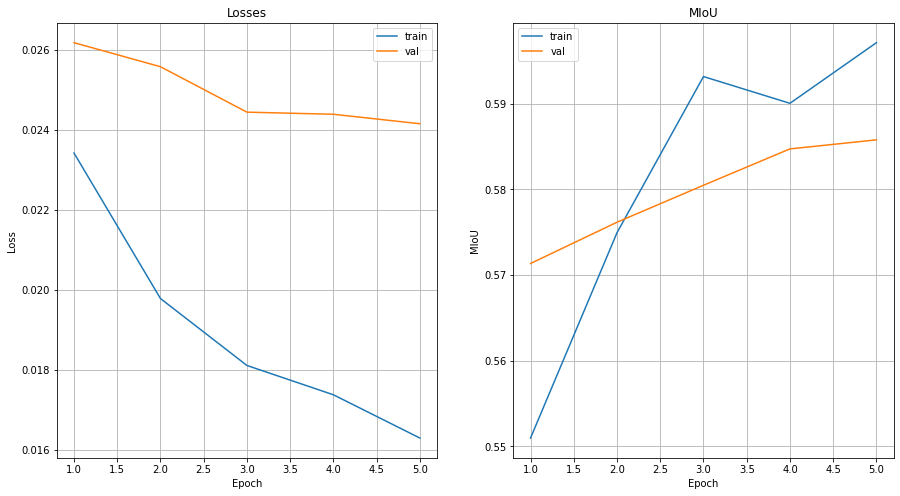

In [19]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='train')
plt.plot(range(1, epochs+1), val_losses, label='val')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_miou, label='train')
plt.plot(range(1, epochs+1), val_miou, label='val')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('MIoU')
plt.title('MIoU')

plt.show()

# Результаты модели
Посмотрим, как работает полученная модель

In [20]:
images, labels = next(iter(val_dataloader))
images = images.to(device)
labels = labels.to(device)
preds = model(images)['out']

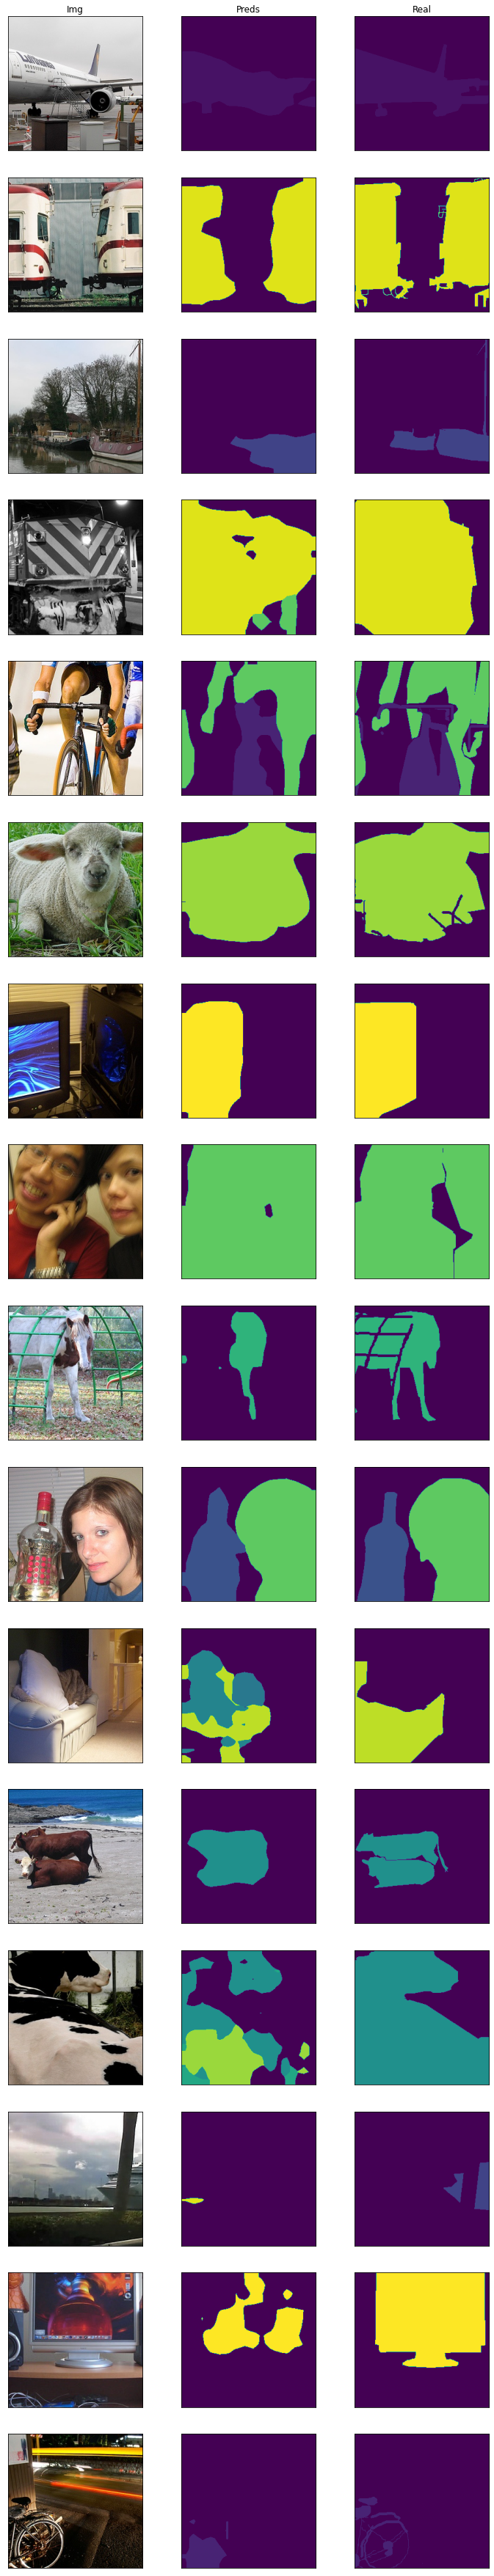

In [21]:
fig, axes = plt.subplots(len(images), 3, figsize=(12, len(images)*4))

for i, (img, pred, label) in enumerate(zip(images.detach().cpu(), preds.detach().cpu().softmax(1), labels.detach().cpu())):
    axes[i, 0].imshow(img.permute(1,2,0))
    axes[i, 1].imshow(pred.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)
    axes[i, 2].imshow(label.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)

[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.axes[0].set_title('Img')
fig.axes[1].set_title('Preds')
fig.axes[2].set_title('Real')

fig.show()

Видим, что модель достаточно хорошо справляется с сегментацией.

Провалидируем модель на всех картинках, чтобы лучше исследовать результаты. Сами результаты пока хранить не будем, тк памяти не хватит

In [22]:
val_iou = None
val_miou = None

with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)['out']
        iou = IoU(labels.detach().cpu(), preds.detach().cpu())
        miou = MIoU(labels.detach().cpu(), preds.detach().cpu())

        if val_iou is None:
            val_iou = iou.detach().cpu()
            val_miou = miou.detach().cpu()
        else:
            val_iou = torch.cat((val_iou, iou.detach().cpu()), dim=0)
            val_miou = torch.cat((val_miou, miou.detach().cpu()), dim=0)

100%|██████████| 91/91 [05:15<00:00,  3.47s/it]


Посмотрим на IoU в разбивке по классам

In [23]:
for class_name, class_iou in zip(VOC_CLASSES, val_iou.nanmean(axis=1)):
    print(f'{class_name:13} {class_iou:.3f}')

background    0.570
aeroplane     0.727
bicycle       0.672
bird          0.398
boat          0.620
bottle        0.901
bus           0.946
car           0.637
cat           0.590
chair         0.837
cow           0.307
diningtable   0.863
dog           0.163
horse         0.308
motorbike     0.400
person        0.509
potted plant  0.183
sheep         0.852
sofa          0.410
train         0.008
tv/monitor    0.939


Видим, что на некоторых классах IoU довольно высокий (bus, bottle, tv/monitor), но на некоторых наоборот низкий (train, dog).


Теперь возьмем по три картинки из следующих "классов":
* картинки, попадающие в топ 10% по качеству сегментации
* картинки, попадающие в топ 15-25% по качеству сегментации
* картинки, попадающие в топ 45-55% по качеству сегментации

Брать буду первые попавшиеся картинки, подходящие под одно их условий

Посмотрим, как сработала сегментация на выбранных картинках

In [75]:
q_90 = torch.quantile(val_miou, 0.9).item()
q_85 = torch.quantile(val_miou, 0.85).item()
q_75 = torch.quantile(val_miou, 0.75).item()
q_55 = torch.quantile(val_miou, 0.55).item()
q_45 = torch.quantile(val_miou, 0.45).item()

In [76]:
pictures_class1 = None
labels_class1 = None
preds_class1 = None

pictures_class2 = None
labels_class2 = None
preds_class2 = None

pictures_class3 = None
labels_class3 = None
preds_class3 = None

In [77]:
with torch.no_grad():
    for images, labels in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)['out']
        miou = MIoU(labels.detach().cpu(), preds.detach().cpu())
        # чутка поговнокодим
        for i in range(len(miou)):
            cur_miou = miou[i].item()
            if cur_miou > q_90:
                if pictures_class1 is None:
                    pictures_class1 = images[i].detach().cpu().unsqueeze(0)
                    labels_class1 = labels[i].detach().cpu().unsqueeze(0)
                    preds_class1 = preds[i].detach().cpu().unsqueeze(0)
                elif len(pictures_class1) < 3:
                    pictures_class1 = torch.cat((pictures_class1, images[i].detach().cpu().unsqueeze(0)), dim=0)
                    labels_class1 = torch.cat((labels_class1, labels[i].detach().cpu().unsqueeze(0)), dim=0)
                    preds_class1 = torch.cat((preds_class1, preds[i].detach().cpu().unsqueeze(0)), dim=0)
                else:
                    continue
            
            elif q_75 <= cur_miou < q_85:
                if pictures_class2 is None:
                    pictures_class2 = images[i].detach().cpu().unsqueeze(0)
                    labels_class2 = labels[i].detach().cpu().unsqueeze(0)
                    preds_class2 = preds[i].detach().cpu().unsqueeze(0)
                elif len(pictures_class2) < 3:
                    pictures_class2 = torch.cat((pictures_class2, images[i].detach().cpu().unsqueeze(0)), dim=0)
                    labels_class2 = torch.cat((labels_class2, labels[i].detach().cpu().unsqueeze(0)), dim=0)
                    preds_class2 = torch.cat((preds_class2, preds[i].detach().cpu().unsqueeze(0)), dim=0)
                else:
                    continue
            
            elif q_45 <= cur_miou < q_55:
                if pictures_class3 is None:
                    pictures_class3 = images[i].detach().cpu().unsqueeze(0)
                    labels_class3 = labels[i].detach().cpu().unsqueeze(0)
                    preds_class3 = preds[i].detach().cpu().unsqueeze(0)
                elif len(pictures_class3) < 3:
                    pictures_class3 = torch.cat((pictures_class3, images[i].detach().cpu().unsqueeze(0)), dim=0)
                    labels_class3 = torch.cat((labels_class3, labels[i].detach().cpu().unsqueeze(0)), dim=0)
                    preds_class3 = torch.cat((preds_class3, preds[i].detach().cpu().unsqueeze(0)), dim=0)
                else:
                    continue

        if pictures_class1 is not None and len(pictures_class1) == 3 \
            and pictures_class2 is not None and len(pictures_class2) == 3 \
            and pictures_class3 is not None and len(pictures_class3) == 3:
            break

Топ 10%:

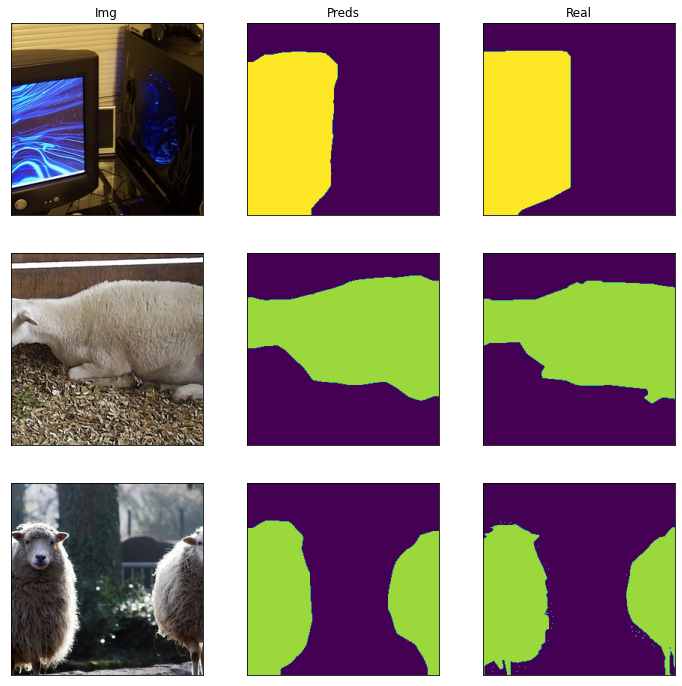

In [78]:
fig, axes = plt.subplots(len(pictures_class1), 3, figsize=(12, len(pictures_class1)*4))

for i, (img, pred, label) in enumerate(zip(pictures_class1, preds_class1.softmax(1), labels_class1)):
    axes[i, 0].imshow(img.permute(1, 2, 0))
    axes[i, 1].imshow(pred.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)
    axes[i, 2].imshow(label.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)

[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.axes[0].set_title('Img')
fig.axes[1].set_title('Preds')
fig.axes[2].set_title('Real')

fig.show()

Топ 15-25%:

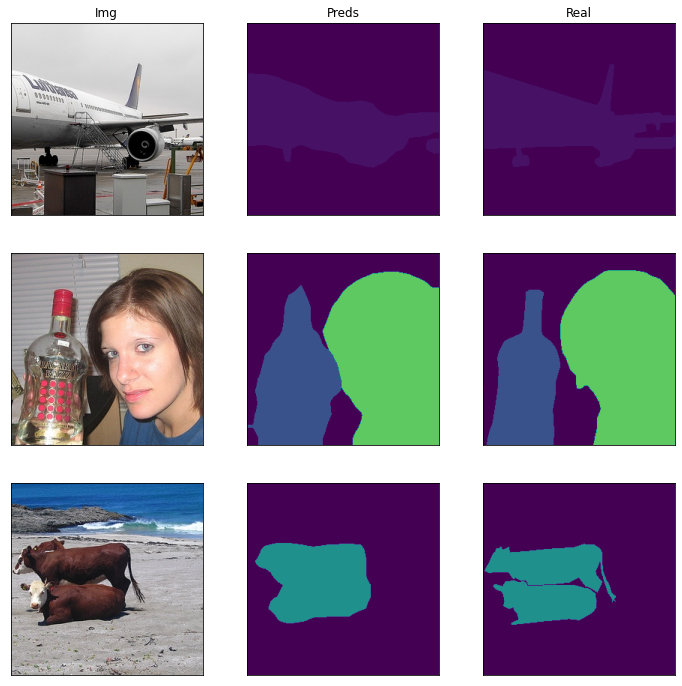

In [79]:
fig, axes = plt.subplots(len(pictures_class2), 3, figsize=(12, len(pictures_class2)*4))

for i, (img, pred, label) in enumerate(zip(pictures_class2, preds_class2.softmax(1), labels_class2)):
    axes[i, 0].imshow(img.permute(1,2,0))
    axes[i, 1].imshow(pred.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)
    axes[i, 2].imshow(label.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)

[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.axes[0].set_title('Img')
fig.axes[1].set_title('Preds')
fig.axes[2].set_title('Real')

fig.show()

Топ 45-55%:

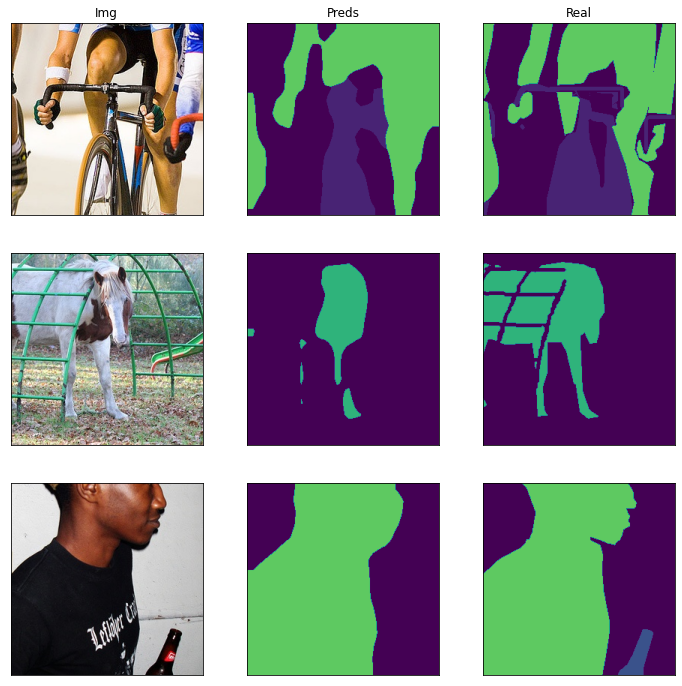

In [80]:
fig, axes = plt.subplots(len(pictures_class3), 3, figsize=(12, len(pictures_class3)*4))

for i, (img, pred, label) in enumerate(zip(pictures_class3, preds_class3.softmax(1), labels_class3)):
    axes[i, 0].imshow(img.permute(1,2,0))
    axes[i, 1].imshow(pred.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)
    axes[i, 2].imshow(label.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)

[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.axes[0].set_title('Img')
fig.axes[1].set_title('Preds')
fig.axes[2].set_title('Real')

fig.show()

Картинки, входящие в топ-10 сегментируются почти идеально. Картинки в топ 15-25% сегментируются тоже хорошо, но менее точно - контуры объектов местами сильно непохожи. Картинки в топ 45-55% сегментируются еще менее точноо - некоторая часть объекта на картинке классифицируется вообще к другим классам

# Вывод

В данной работе я решал задачу многоклассовой семантической сегментации на датасете Pascal VOC. Для решения я использовал предобученную сеть deeplabv3_mobilenet_large_v3. При обучении на 5 эпохах я получил MIoU = 0.59 на валидационной выборке. Причем на некоторых классах эта метрика поднимается аж до 0.9, но на некоторых классах она наоборот близка к нулю.